# Validation Layer

## **Description:**

- Now you have to create validation schema and produce simple model running on it
    - Create a validation class
    - Create a simpe model
    - Create a simpe feature extraction step
- No extensive modeling or feature extraction is required, we need just to ensure our modeling step is trustworthy:
    - We don't have any target leakage
    - Our validation results are very close to the production behaviour
    - We have enough validation data to rank our model results
- Prepare a simple picture that would describe your schema:
    - Decalre Train/Validation/Test splits
    - Define validation approach
    - Define the way you exrtact features that won't have target or data leakage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import scripts.validate as validate # validate.py module

## Load and transform **train, test** datasets

In [2]:
train_df = pd.read_csv('../data/result_train.csv')
test_df = pd.read_csv('../data/result_test.csv')

In [3]:
float_columns = train_df.select_dtypes(include=np.number).columns.tolist()
object_columns = train_df.select_dtypes(include=object).columns.tolist()

train_df = validate.transform_df_types(train_df, int_columns=[], float_columns=float_columns, object_columns=object_columns)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 37 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   date_block_num                  1608724 non-null  float32 
 1   shop_id                         1608724 non-null  float32 
 2   item_id                         1608724 non-null  float32 
 3   item_cnt_month                  1608724 non-null  float32 
 4   item_price                      1608724 non-null  float32 
 5   month                           1608724 non-null  float32 
 6   year                            1608724 non-null  float32 
 7   item_name                       1608724 non-null  category
 8   item_category_id                1608724 non-null  float32 
 9   item_category_name              1608724 non-null  category
 10  shop_name                       1608724 non-null  category
 11  months_since_last_sale          1608724 non-null  

In [4]:
float_columns = test_df.select_dtypes(include=np.number).columns.tolist()
object_columns = test_df.select_dtypes(include=object).columns.tolist()

test_df = validate.transform_df_types(test_df, int_columns=[], float_columns=float_columns, object_columns=object_columns)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214284 entries, 0 to 214283
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   ID                              214284 non-null  float32 
 1   shop_id                         214284 non-null  float32 
 2   item_id                         214284 non-null  float32 
 3   item_name                       214284 non-null  category
 4   item_category_id                214284 non-null  float32 
 5   item_category_name              214284 non-null  category
 6   shop_name                       214284 non-null  category
 7   months_since_last_sale          214284 non-null  float32 
 8   revenue_lag_1                   214284 non-null  float32 
 9   revenue_lag_2                   214284 non-null  float32 
 10  revenue_lag_3                   214284 non-null  float32 
 11  revenue_lag_6                   214284 non-null  float32 
 12  re

## Build a simple validation split class

In [5]:
class TimeSeriesSplit:
    """
    The splits are created basing on the 'date_block_num' feature

    Attributes:
        n_splits: the number of train:test pairs to return
        trait_start: first month number to be included in splits
    """

    def __init__(self, n_splits=5, train_start=0):
        self.n_splits = n_splits
        self.train_start = train_start

    def split_expanding(self, X):
        n_months = X['date_block_num'].max() + 1

        for i in range(self.n_splits, 0, -1):
            train_idx = (X['date_block_num'] < n_months - i) & (X['date_block_num'] >= self.train_start)
            test_idx = X['date_block_num'] == n_months - i

            yield train_idx, test_idx

    def split_sliding(self, X):
        n_months = X['date_block_num'].max() + 1
        m_in_split = n_months // self.n_splits # number of months in a single split (perhaps, except for the last one)

        for i in range(1, self.n_splits):
            train_idx = (X['date_block_num'] < i * m_in_split - 1) & (X['date_block_num'] >= m_in_split * (i - 1))
            test_idx = X['date_block_num'] == i * m_in_split - 1

            yield train_idx, test_idx
        
        train_idx = (X['date_block_num'] < n_months - 1) & (X['date_block_num'] >= m_in_split * (self.n_splits - 1)) # all indexes left go to the last block
        test_idx = X['date_block_num'] == n_months - 1

        yield train_idx, test_idx

### Check how **split_expanding(df)** works

In [6]:
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split_expanding(train_df):
    train = train_df[train_idx]
    test = train_df[test_idx]
    print("Train set months:", train['date_block_num'].min(), train['date_block_num'].max())
    print("Test set months", test['date_block_num'].min(), test['date_block_num'].max())
    print()

Train set months: 0.0 28.0
Test set months 29.0 29.0

Train set months: 0.0 29.0
Test set months 30.0 30.0

Train set months: 0.0 30.0
Test set months 31.0 31.0

Train set months: 0.0 31.0
Test set months 32.0 32.0

Train set months: 0.0 32.0
Test set months 33.0 33.0



### Check how **split_sliding(df)** works

In [7]:
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split_sliding(train_df):
    train = train_df[train_idx]
    test = train_df[test_idx]
    print("Train set months:", train['date_block_num'].min(), train['date_block_num'].max())
    print("Test set months", test['date_block_num'].min(), test['date_block_num'].max())
    print()

Train set months: 0.0 4.0
Test set months 5.0 5.0

Train set months: 6.0 10.0
Test set months 11.0 11.0

Train set months: 12.0 16.0
Test set months 17.0 17.0

Train set months: 18.0 22.0
Test set months 23.0 23.0

Train set months: 24.0 32.0
Test set months 33.0 33.0



## Clean train set from unneeded columns

In [8]:
train_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price',
       'month', 'year', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'months_since_last_sale', 'revenue', 'revenue_lag_1',
       'revenue_lag_2', 'revenue_lag_3', 'revenue_lag_6', 'revenue_lag_12',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'item_cnt_month_cat__lag_1', 'item_cnt_month_cat__lag_2',
       'item_cnt_month_cat__lag_3', 'item_cnt_month_cat_shop__lag_1',
       'item_cnt_month_cat_shop__lag_2', 'item_cnt_month_cat_shop__lag_3',
       'days', 'avg_item_price', 'avg_item_price_lag_1',
       'avg_item_price_lag_2', 'avg_item_price_lag_3', 'avg_item_price_lag_4',
       'avg_item_price_lag_5', 'avg_item_price_lag_6'],
      dtype='object')

In [9]:
train = train_df.select_dtypes(include=np.number)
y = train['item_cnt_month']
X = train.drop(['item_cnt_month', 'item_price', 'revenue', 'avg_item_price'], axis=1, inplace=False)

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 30 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1608724 non-null  float32
 1   shop_id                         1608724 non-null  float32
 2   item_id                         1608724 non-null  float32
 3   month                           1608724 non-null  float32
 4   year                            1608724 non-null  float32
 5   item_category_id                1608724 non-null  float32
 6   months_since_last_sale          1608724 non-null  float32
 7   revenue_lag_1                   1608724 non-null  float32
 8   revenue_lag_2                   1608724 non-null  float32
 9   revenue_lag_3                   1608724 non-null  float32
 10  revenue_lag_6                   1608724 non-null  float32
 11  revenue_lag_12                  1608724 non-null  float32
 12  

### It's important to note, that before the training process we need to remove the **date_block_num** column

## Train simple model

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

## Use XGBoost as a base model

In [13]:
from xgboost import XGBRegressor

In [14]:
scores = []
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split_expanding(X):
    X_new = X.copy()
    X_new.drop('date_block_num', axis=1, inplace=True)
    X_train, X_test = X_new[train_idx], X_new[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # -> scaling is not necessary for GB models; moreover, scaling removes feature names from the "plot_importance" method
    
    model = XGBRegressor(
    max_depth=7,
    # n_estimators=1000, 
    eta=0.05,    
    eval_metric="rmse",
    early_stopping_rounds=30)

    model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True)

    y_pred = model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    print(f"RMSE: {score:.2f}")
    print()

[0]	validation_0-rmse:2.55609	validation_1-rmse:2.17969
[1]	validation_0-rmse:2.50768	validation_1-rmse:2.13361
[2]	validation_0-rmse:2.46348	validation_1-rmse:2.09421
[3]	validation_0-rmse:2.42219	validation_1-rmse:2.05377
[4]	validation_0-rmse:2.38464	validation_1-rmse:2.01765
[5]	validation_0-rmse:2.34991	validation_1-rmse:1.98364
[6]	validation_0-rmse:2.31769	validation_1-rmse:1.95553
[7]	validation_0-rmse:2.28744	validation_1-rmse:1.92782
[8]	validation_0-rmse:2.26014	validation_1-rmse:1.90057
[9]	validation_0-rmse:2.23455	validation_1-rmse:1.87764
[10]	validation_0-rmse:2.21116	validation_1-rmse:1.85465
[11]	validation_0-rmse:2.18942	validation_1-rmse:1.83542
[12]	validation_0-rmse:2.16965	validation_1-rmse:1.81747
[13]	validation_0-rmse:2.15099	validation_1-rmse:1.80063
[14]	validation_0-rmse:2.13427	validation_1-rmse:1.78449
[15]	validation_0-rmse:2.11861	validation_1-rmse:1.76935
[16]	validation_0-rmse:2.10378	validation_1-rmse:1.75615
[17]	validation_0-rmse:2.09034	validation

In [15]:
print(f"RMSE: {np.mean(scores):.2f}")

RMSE: 1.68


# Use XGBoost with sliding window

In [16]:
from xgboost import XGBRegressor

In [17]:
scores = []
tscv = TimeSeriesSplit(n_splits=3)

for train_idx, test_idx in tscv.split_sliding(X):
    X_new = X.copy()
    X_new.drop('date_block_num', axis=1, inplace=True)
    X_train, X_test = X_new[train_idx], X_new[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model2 = XGBRegressor(
    max_depth=7,
    n_estimators=1000,
    eta=0.05,    
    eval_metric="rmse",
    early_stopping_rounds=30)

    model2.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True)

    y_pred = model2.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    print(f"RMSE: {score:.2f}")
    print()

[0]	validation_0-rmse:2.49915	validation_1-rmse:2.87944
[1]	validation_0-rmse:2.45457	validation_1-rmse:2.83195
[2]	validation_0-rmse:2.41336	validation_1-rmse:2.78848
[3]	validation_0-rmse:2.37470	validation_1-rmse:2.74064
[4]	validation_0-rmse:2.33986	validation_1-rmse:2.70443
[5]	validation_0-rmse:2.30700	validation_1-rmse:2.66538
[6]	validation_0-rmse:2.27746	validation_1-rmse:2.63014
[7]	validation_0-rmse:2.25006	validation_1-rmse:2.59941
[8]	validation_0-rmse:2.22427	validation_1-rmse:2.57065
[9]	validation_0-rmse:2.20013	validation_1-rmse:2.54040
[10]	validation_0-rmse:2.17772	validation_1-rmse:2.51550
[11]	validation_0-rmse:2.15805	validation_1-rmse:2.49089
[12]	validation_0-rmse:2.13954	validation_1-rmse:2.46880
[13]	validation_0-rmse:2.12248	validation_1-rmse:2.44867
[14]	validation_0-rmse:2.10582	validation_1-rmse:2.42906
[15]	validation_0-rmse:2.09050	validation_1-rmse:2.41001
[16]	validation_0-rmse:2.07651	validation_1-rmse:2.39566
[17]	validation_0-rmse:2.06437	validation

In [18]:
print(f"RMSE: {np.mean(scores):.2f}")

RMSE: 2.18


### As we can see, **sliding window validation** doesn't produce enough **train data** in a single split to achieve a good model quality

## Try deleting highly correlated features and check if this improves the model quality

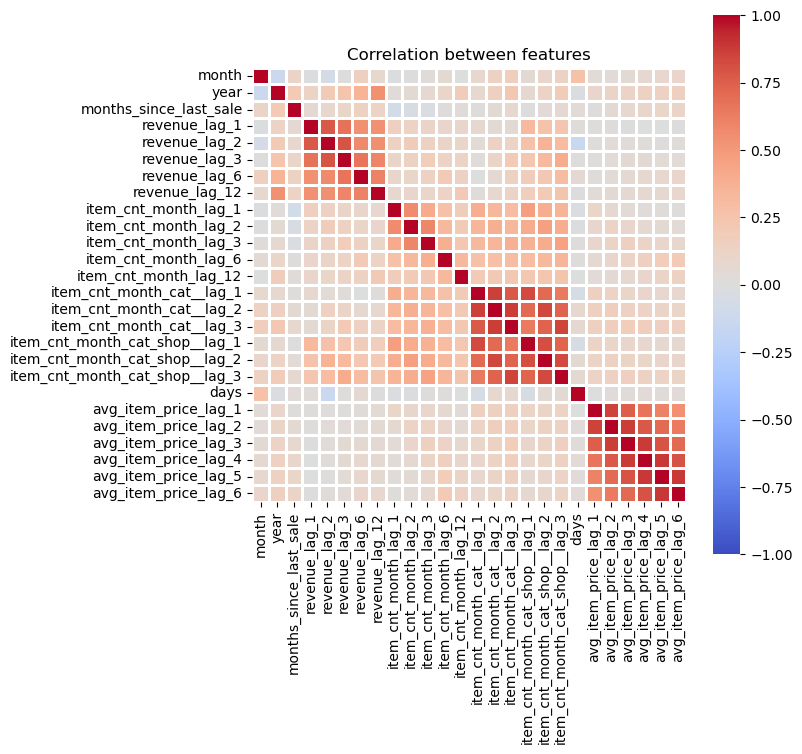

In [19]:
import seaborn as sns

numeric_train_df = X.copy()
numeric_train_df.drop(['date_block_num', 'item_id', 'item_category_id', 'shop_id'], axis=1, inplace=True)
f, ax = plt.subplots()
f.set_size_inches(7, 7)
ax.set_title("Correlation between features")
sns.heatmap(numeric_train_df.corr(), vmin=-1, vmax=1, center=0, cmap='coolwarm', linewidths=2, square=True);

In [20]:
X.columns

Index(['date_block_num', 'shop_id', 'item_id', 'month', 'year',
       'item_category_id', 'months_since_last_sale', 'revenue_lag_1',
       'revenue_lag_2', 'revenue_lag_3', 'revenue_lag_6', 'revenue_lag_12',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'item_cnt_month_cat__lag_1', 'item_cnt_month_cat__lag_2',
       'item_cnt_month_cat__lag_3', 'item_cnt_month_cat_shop__lag_1',
       'item_cnt_month_cat_shop__lag_2', 'item_cnt_month_cat_shop__lag_3',
       'days', 'avg_item_price_lag_1', 'avg_item_price_lag_2',
       'avg_item_price_lag_3', 'avg_item_price_lag_4', 'avg_item_price_lag_5',
       'avg_item_price_lag_6'],
      dtype='object')

In [21]:
X_less_corr = X.copy()
X_less_corr.drop(['revenue_lag_2', 'revenue_lag_3', 'item_cnt_month_cat__lag_2', 'item_cnt_month_cat__lag_3', 
                  'item_cnt_month_cat_shop__lag_2', 'item_cnt_month_cat_shop__lag_3', 'avg_item_price_lag_3', 'avg_item_price_lag_4', 'avg_item_price_lag_5'], axis=1, inplace=True)

In [22]:
scores = []
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split_expanding(X):
    X_new = X_less_corr.copy()
    X_new.drop('date_block_num', axis=1, inplace=True)
    X_train, X_test = X_new[train_idx], X_new[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model2 = XGBRegressor(
    max_depth=7,
    n_estimators=1000,
    eta=0.05,    
    eval_metric="rmse",
    early_stopping_rounds=30)

    model2.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True)

    y_pred = model2.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    print(f"RMSE: {score:.2f}")
    print()

[0]	validation_0-rmse:2.55621	validation_1-rmse:2.17942
[1]	validation_0-rmse:2.50793	validation_1-rmse:2.13291
[2]	validation_0-rmse:2.46396	validation_1-rmse:2.09363
[3]	validation_0-rmse:2.42276	validation_1-rmse:2.05318
[4]	validation_0-rmse:2.38524	validation_1-rmse:2.01648
[5]	validation_0-rmse:2.35078	validation_1-rmse:1.98579
[6]	validation_0-rmse:2.31840	validation_1-rmse:1.95407
[7]	validation_0-rmse:2.28823	validation_1-rmse:1.92678
[8]	validation_0-rmse:2.26102	validation_1-rmse:1.89957
[9]	validation_0-rmse:2.23543	validation_1-rmse:1.87734
[10]	validation_0-rmse:2.21229	validation_1-rmse:1.85519
[11]	validation_0-rmse:2.19049	validation_1-rmse:1.83469
[12]	validation_0-rmse:2.17058	validation_1-rmse:1.81623
[13]	validation_0-rmse:2.15243	validation_1-rmse:1.79866
[14]	validation_0-rmse:2.13549	validation_1-rmse:1.78468
[15]	validation_0-rmse:2.12011	validation_1-rmse:1.77137
[16]	validation_0-rmse:2.10564	validation_1-rmse:1.75828
[17]	validation_0-rmse:2.09227	validation

In [23]:
print(f"RMSE: {np.mean(scores):.2f}")

RMSE: 1.66


### Deleting 9 highly-correlated features from the dataset didn't worsen the score (1.66 now vs 1.68 then). I will keep the dataset in this form for further work

## Before calculating feature importances, I'll tune hyperparameters of XGBoost model

I'll do this first because feature importance information is not relevant when measured on a bad model

## Try to use XGBoost feature importance information to find relevant features 

I will use the model left from the first XGboost training process

In [24]:
from xgboost import plot_importance

def plot_features(booster, figsize, importance_type="weight"):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, importance_type=importance_type, values_format="{v:.2f}")

There are 3 ways of how the importance is calculated:
- ”weight” is the number of times a feature appears in a tree
- ”gain” is the average gain of splits which use the feature
- ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

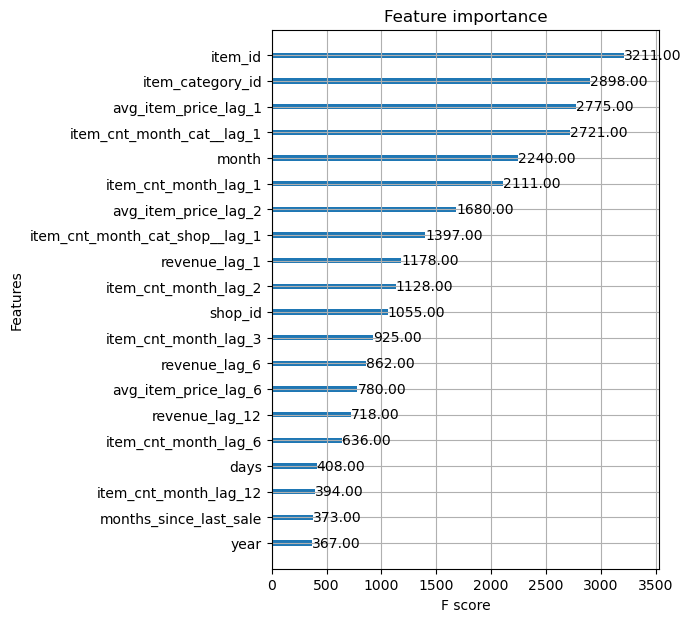

In [25]:
plot_features(model2, (5, 7), importance_type="weight");

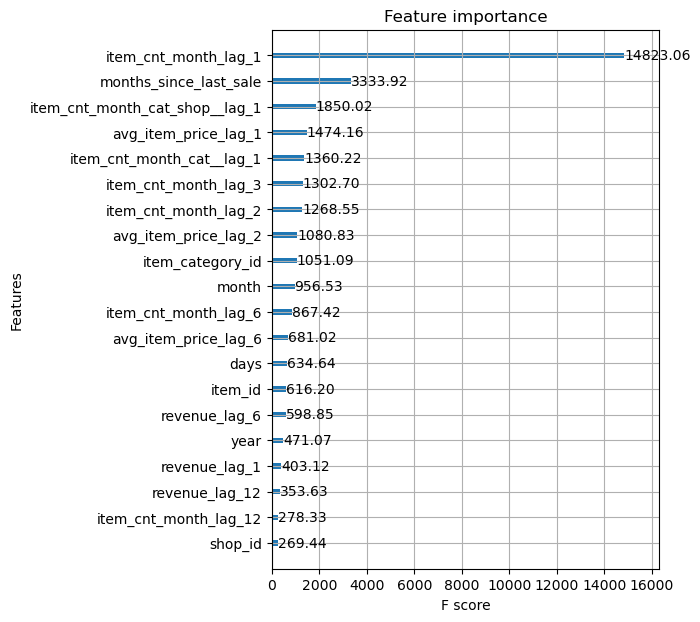

In [26]:
plot_features(model2, (5, 7), importance_type="gain");

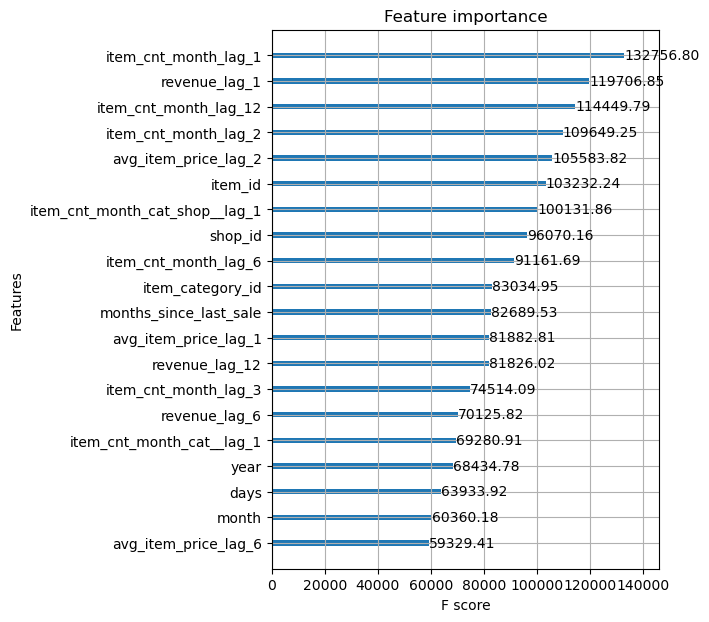

In [27]:
plot_features(model2, (5, 7), importance_type="cover");

### All three graphs provide different answers; this means, that we need to determine which metric is the best for the dataset. I believe there are more accurate ways to calculate less biased feature importances 

## Permutation based feature importance

### First calculate X, y 

In [28]:
tscv = TimeSeriesSplit(n_splits=1)

for train_idx, test_idx in tscv.split_expanding(X_less_corr):
    X_new = X_less_corr.copy()
    X_new.drop('date_block_num', axis=1, inplace=True)
    X_train, X_test = X_new[train_idx], X_new[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [29]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(model2, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

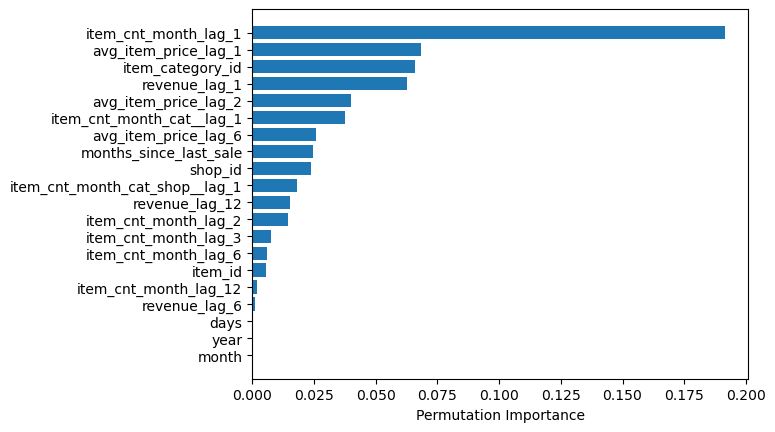

In [30]:
sorted_idx = perm.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], perm.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### Permutation-based method can be inaccurate with **highly correlated features** (it's still more or less a characteristic for our dataset because of some lagged features in it)

## **SHAP** is known to be one of the most consistent and accurate methods for calculating feature importances - let's use it now

In [31]:
from shap import TreeExplainer, plots

In [32]:
explainer = TreeExplainer(model2, X_test)
shap_values = explainer(X_test)

100%|===================| 31388/31531 [03:40<00:01]        

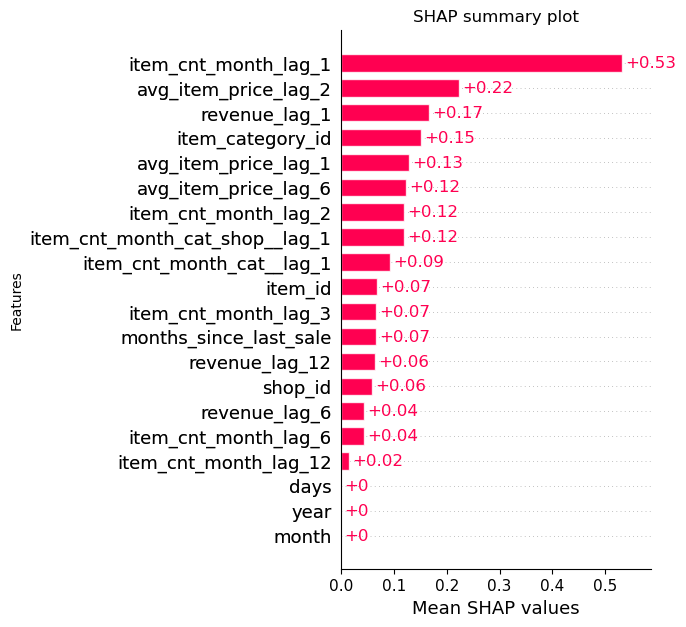

In [34]:
fig, ax = plt.subplots()

plots.bar(shap_values, show=False, max_display=20)
fig.set_size_inches(4, 7)
ax.set_title("SHAP summary plot")
ax.set_xlabel("Mean SHAP values")
ax.set_ylabel("Features");

In [35]:
shap_values.feature_names

['shop_id',
 'item_id',
 'month',
 'year',
 'item_category_id',
 'months_since_last_sale',
 'revenue_lag_1',
 'revenue_lag_6',
 'revenue_lag_12',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_cnt_month_lag_6',
 'item_cnt_month_lag_12',
 'item_cnt_month_cat__lag_1',
 'item_cnt_month_cat_shop__lag_1',
 'days',
 'avg_item_price_lag_1',
 'avg_item_price_lag_2',
 'avg_item_price_lag_6']